### Imports

In [127]:
from nltk.corpus import movie_reviews as reviews
from sklearn.datasets import fetch_20newsgroups
from gensim.models import KeyedVectors
from gensim.models import word2vec

import numpy as np
import pandas as pd
import re
import datetime
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import *
import tensorflow as tf
from random import randint

import os
import time
import string
import pickle

from operator import itemgetter

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.stem.snowball import SnowballStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report as clsr
from sklearn.metrics import precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, SpatialDropout1D, Activation
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import pdfminer

ImportError: No module named 'pdfminer'

### Data retrieving

In [16]:
# Loading the data set - training data.
X = [reviews.raw(fileid) for fileid in reviews.fileids()]
y = [reviews.categories(fileid)[0] for fileid in reviews.fileids()]

In [106]:
data = pd.DataFrame(
    {'text': X,'label': y})
data['text length'] = data['text'].apply(len)

In [51]:
data_essays = pd.read_csv('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Text/essays.csv', encoding = "ISO-8859-1")
data_essays['cEXT'] = np.where(data_essays['cEXT']=='y', 1, 0)
data_essays['cNEU'] = np.where(data_essays['cNEU']=='y', 1, 0)
data_essays['cAGR'] = np.where(data_essays['cAGR']=='y', 1, 0)
data_essays['cCON'] = np.where(data_essays['cCON']=='y', 1, 0)
data_essays['cOPN'] = np.where(data_essays['cOPN']=='y', 1, 0)
X_essays = data_essays['TEXT'].tolist()
y_essays = data_essays[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']]

### Visualization

Text length distrbution for the different labels

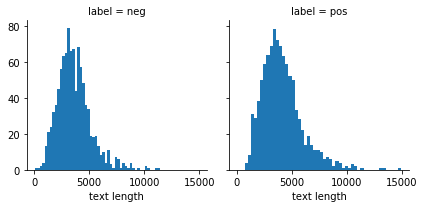

In [90]:
 g = sns.FacetGrid(data=data, col='label')
g.map(plt.hist, 'text length', bins=50)

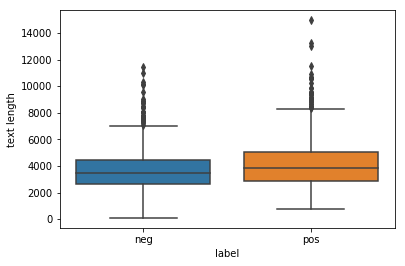

In [92]:
sns.boxplot(x='label', y='text length', data=data)

Most common words in the corpus

In [77]:
complete_corpus = ' '.join(X)
words = tokenize.word_tokenize(complete_corpus)
fdist = FreqDist(words)
print(fdist.most_common(100))

[(',', 77717), ('the', 76276), ('.', 65876), ('a', 37986), ('and', 35404), ('of', 33972), ('to', 31772), ('is', 26054), ('in', 21611), ("'s", 18128), ('``', 17625), ('it', 16059), ('that', 15912), (')', 11781), ('(', 11664), ('as', 11349), ('with', 10782), ('for', 9918), ('this', 9573), ('his', 9569), ('film', 9443), ('i', 8846), ('he', 8840), ('but', 8604), ('on', 7249), ('are', 7204), ('by', 6218), ("n't", 6217), ('be', 6083), ('an', 5742), ('who', 5680), ('not', 5672), ('movie', 5671), ('one', 5582), ('you', 5286), ('was', 5225), ('have', 5046), ('from', 4987), ('at', 4972), ('they', 4815), ('has', 4811), ('her', 4508), ('all', 4259), ('?', 3771), ('there', 3758), ('so', 3585), ('like', 3547), ('about', 3518), ('out', 3442), ('more', 3342), ('what', 3310), ('when', 3255), ('which', 3160), ('she', 3129), ('their', 3117), ('up', 3108), ('or', 3106), ('do', 3090), (':', 3042), ('some', 2981), ('just', 2901), ('does', 2834), ('if', 2792), ('we', 2761), ('him', 2631), ('into', 2618), ('e

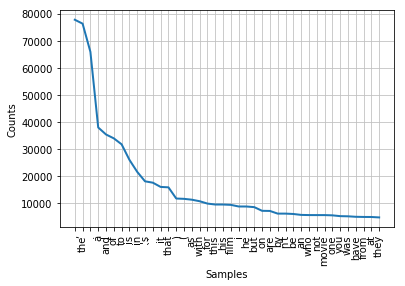

In [10]:
fdist.plot(40)

### Manual modeling

In [14]:
# Custom Stemming
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

#### MultinomialNB

In [ ]:
# Grid Search
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])
text_clf = text_clf.fit(X, y)
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}
gs_clf = GridSearchCV(text_clf, parameters, cv = 5, n_jobs=-1)
gs_clf = gs_clf.fit(X, y)
print("Best params : {}".format(gs_clf.best_params_))
print("Best score : {}".format(gs_clf.best_score_))

In [19]:
# Model fitting
X_train, X_test, y_train, y_test = tts(X, LabelEncoder().fit_transform(y), test_size=0.25, random_state=1)
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_clf = Pipeline([('vect', StemmedCountVectorizer(stop_words='english', ngram_range =  (1, 2))), ('tfidf', TfidfTransformer(use_idf = True)), 
                     ('clf', MultinomialNB(alpha = 0.01))])
text_model = text_clf.fit(X_train, y_train)
predicted = text_model.predict(X_test)
print(np.mean(predicted == y_test))

0.782


#### Support Vector Machines

In [ ]:
# Grid Search
text_clf_svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42))])
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf-svm__alpha': (1e-2, 1e-3)}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, cv = 5, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(twenty_train.data, twenty_train.target)
print("Best params : {}".format(gs_clf_svm.best_params_))
print("Best score : {}".format(gs_clf_svm.best_score_))

In [20]:
# Model fitting
X_train, X_test, y_train, y_test = tts(X, LabelEncoder().fit_transform(y), test_size=0.25, random_state=1)
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_clf_svm = Pipeline([('vect', StemmedCountVectorizer(stop_words='english', ngram_range =  (1, 2))), ('tfidf', TfidfTransformer(use_idf = True)),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42))])
text_model_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_model_svm.predict(X_test)
print(np.mean(predicted_svm == y_test))

0.796


### Complete Modeling

In [124]:
class MyRNNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rnn, neural_network):
        self.rnn = rnn
        self.neural_network = neural_network

    def fit(self, X, y):
        batch_size = 15
        epochs = 50
        if self.neural_network: 
            self.rnn.fit(X, y, epochs = epochs, batch_size=batch_size, verbose = 2)
            return self
        else :
            self.rnn.fit(X, y)
            return self

    def transform(self, X):
        if self.neural_network:
            self.pred = self.rnn.predict_proba(X)
        else :
            self.pred = self.rnn.predict_proba(X)
        self.classes = [[0 if el < 0.2 else 1 for el in item] for item in self.pred]
        return self.classes
        
    

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})


def genericize_mentions(text):
    return re.sub(r'@[\w_-]+', 'thisisanatmention', text)


def reshape_a_feature_column(series):
    return np.reshape(np.asarray(series), (len(series), 1))


def pipelinize_feature(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            processed = [function(i) for i in list_or_series]
            processed = reshape_a_feature_column(processed)
            return processed
#         This is incredibly stupid and hacky, but we need it to do a grid search with activation/deactivation.
#         If a feature is deactivated, we're going to just return a column of zeroes.
#         Zeroes shouldn't affect the regression, but other values may.
#         If you really want brownie points, consider pulling out that feature column later in the pipeline.
        else:
            return reshape_a_feature_column(np.zeros(len(list_or_series)))

def get_text_length(text):
    return len(text)


def timeit(func):
    """
    Simple timing decorator
    """
    def wrapper(*args, **kwargs):
        start  = time.time()
        result = func(*args, **kwargs)
        delta  = time.time() - start
        return result, delta
    return wrapper


def identity(arg):
    """
    Simple identity function works as a passthrough.
    """
    return arg

def multiclass_accuracy(predictions, true):
    count = 0
    for i in range(len(predictions)):
        for j in range(0,4):
            if predictions[i][j] == true[i][j]:
                count += 1
    acc = count / (5*len(predictions))
    return acc

class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    """
    Transforms input data by using NLTK tokenization, lemmatization, and
    other normalization and filtering techniques.
    """

    def __init__(self, corpus, neural_network, stopwords=None, punct=None, lower=True, strip=True):
        """
        Instantiates the preprocessor, which make load corpora, models, or do
        other time-intenstive NLTK data loading.
        """
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = set(stopwords) if stopwords else set(sw.words('english'))
        self.punct      = set(punct) if punct else set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        self.neural_network = neural_network
        self.corpus = corpus

    def fit(self, X, y=None):
        """
        Fit simply returns self, no other information is needed.
        """
        return self

    def inverse_transform(self, X):
        """
        No inverse transformation
        """
        return X

    def transform(self, X):
        """
        Actually runs the preprocessing on each document.
        """
        if self.neural_network == True:
            output= np.array([(self.tokenize_nn(doc)) for doc in X])
        else :
            output = [self.tokenize(doc) for doc in X]
        return output

        
    def tokenize_nn(self, document, max_features = 30000):
        """
        Returns a normalized, lemmatized list of tokens from a document by
        applying segmentation (breaking into sentences), then word/punctuation
        tokenization, and finally part of speech tagging. It uses the part of
        speech tags to look up the lemma in WordNet, and returns the lowercase
        version of all the words, removing stopwords and punctuation.
        """
        lemmatized_tokens = []
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If punctuation or stopword, ignore token and continue
                if token in self.stopwords or all(char in self.punct for char in token) or len(token)<=1:
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                lemmatized_tokens.append(lemma)

        doc = ' '.join(lemmatized_tokens)
        tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
        return tokenized_document

    def tokenize(self, document, max_features = 30000):
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If punctuation or stopword, ignore token and continue
                if token in self.stopwords or all(char in self.punct for char in token) or len(token)<=1:
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma


    def vectorize(self, doc):
        save_path = "/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/padding.pickle"
        with open(save_path, 'rb') as f:
            tokenizer = pickle.load(f)
        doc_pad = tokenizer.texts_to_sequences(doc)
        doc_pad = pad_sequences(doc_pad, padding = 'pre', truncating = 'pre', maxlen = 350)
        return np.squeeze(doc_pad)


    def lemmatize(self, token, tag):
        """
        Converts the Penn Treebank tag to a WordNet POS tag, then uses that
        tag to perform much more accurate WordNet lemmatization.
        """
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)
    
    
@timeit
def build_and_evaluate(X, y, neural_network, y_format, multiclass, classifier=SGDClassifier, model_name=None, verbose=True):
    """
    Builds a classifer for the given list of documents and targets in two
    stages: the first does a train/test split and prints a classifier report,
    the second rebuilds the model on the entire corpus and returns it for
    operationalization.
    X: a list or iterable of raw strings, each representing a document.
    y: a list or iterable of labels, which will be label encoded.
    Can specify the classifier to build with: if a class is specified then
    this will build the model with the Scikit-Learn defaults, if an instance
    is given, then it will be used directly in the build pipeline.
    If model_name is given, this function will write the model as a pickle.
    If verbose, this function will print out information to the command line.
    """

    @timeit
    def build(classifier, X, y, neural_network, corpus):
        """
        Inner build function that builds a single model.
        """
        if isinstance(classifier, type):
            classifier = classifier()
            
        if neural_network:
            model = Pipeline([
            ('preprocessor', NLTKPreprocessor(corpus, neural_network)),
            ('classifier', classifier)
            ])
        else : 
            model = Pipeline([
            ('preprocessor', NLTKPreprocessor(corpus, neural_network)),
            ('features', FeatureUnion([
            ('vectorizer', TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)),
            ('text_length', pipelinize_feature(get_text_length, active=True))
            ])),
            ('classifier', classifier)
            ])
#('genericize_mentions', pipelinize(genericize_mentions)),
        return model.fit(X, y)

    # Label encode the targets
    if y_format:
        y_trans = y
    else:
        if neural_network:
            y_trans= pd.get_dummies(y).values
        else:
            labels = LabelEncoder()
            y_trans = labels.fit_transform(y)
    

    # Begin evaluation
    if verbose: print("Building for evaluation")
    indices = range(len(y))
    X_train, X_test, y_train, y_test, indices_train, indices_test = tts(X, y_trans, indices, test_size=0.2)
    
    if classifier == "RNN":
        classifier = Sequential()
        classifier.add(Embedding(30000, 300,input_length = 350))
        classifier.add(SpatialDropout1D(0.4))
        classifier.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
        classifier.add(Dense(5,activation='softmax'))
        classifier.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
        print(classifier.summary())
    
    model, secs = build(MyRNNTransformer(classifier, neural_network), X_train, y_train, neural_network = True, corpus = X)

    if verbose: print("Evaluation model fit in {:0.3f} seconds".format(secs))
    if verbose: print("Classification Report:\n")

    y_pred = model.transform(X_test)
    if multiclass:
        print(multiclass_accuracy(y_test.values.tolist(), y_pred))
    else:
        labels = LabelEncoder()
        y = labels.fit_transform(y_test)
        print(clsr(y_test, y_pred, target_names=labels.classes_.astype(str)))
    

    if verbose: print("Building complete model and saving ...")
    model, secs = build(MyRNNTransformer(classifier, neural_network), X, y_trans, neural_network = True, corpus = X)
#    model.labels_ = labels

    if verbose: print("Complete model fit in {:0.3f} seconds".format(secs))
    parameters = model.get_params(deep = True)
    if model_name:
        outpath = '/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Models/'
        if neural_network:
            classifier.save_weights(outpath + model_name + '.h5')
            with open(outpath + model_name + '.json', 'w') as json_file:
                json_file.write(classifier.to_json())
        else:
            with open(outpath + model_name, 'wb') as f:
                pickle.dump(model, f)

        print("Model written out to {}".format(model_name))

        
    return model

def load_and_predict(X,y, model_name, corpus, neural_network, multiclass):
    @timeit
    def build(classifier, neural_network, corpus):
        """
        Inner build function that builds a single model.
        """
        if isinstance(classifier, type):
            classifier = classifier()
            
        if neural_network:
            model = Pipeline([
            ('preprocessor', NLTKPreprocessor(corpus, neural_network)),
            ('classifier', classifier)
            ])
        else : 
            model = Pipeline([
            ('preprocessor', NLTKPreprocessor(corpus, neural_network)),
            ('features', FeatureUnion([
            ('vectorizer', TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)),
            ('text_length', pipelinize_feature(get_text_length, active=True))
            ])),
            ('classifier', classifier)
            ])
#('genericize_mentions', pipelinize(genericize_mentions)),
        return model

    if neural_network:
        save_path = '/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Models/'
        json_file = open(save_path + model_name + '.json', 'r')
        classifier = model_from_json(json_file.read())
        classifier.load_weights(save_path + model_name + '.h5')
        classifier.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
        json_file.close()
        model, secs = build(MyRNNTransformer(classifier, neural_network), neural_network, corpus)
        y_pred = model.transform(X)
    else :
        save_path = "/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Models/"
        with open(save_path + model_name + '.pickle', 'rb') as f:
            model = pickle.load(f)
        y_pred = model.transform(X)
    if multiclass:
        print(multiclass_accuracy(y.values.tolist(), y_pred))
    else:
        labels = LabelEncoder()
        y = labels.fit_transform(y)
        print(clsr(y, y_pred, target_names=labels.classes_.astype(str)))

    return y_pred



def show_most_informative_features(model, text=None, n=20):
    """
    Accepts a Pipeline with a classifer and a TfidfVectorizer and computes
    the n most informative features of the model. If text is given, then will
    compute the most informative features for classifying that text.
    Note that this function will only work on linear models with coefs_
    """
    # Extract the vectorizer and the classifier from the pipeline
    vectorizer = model.named_steps['features'].transformer_list[0][1]
    classifier = model.named_steps['classifier']

    # Check to make sure that we can perform this computation
    if not hasattr(classifier, 'coef_'):
        raise TypeError(
            "Cannot compute most informative features on {} model.".format(
                classifier.__class__.__name__
            )
        )

    if text is not None:
        # Compute the coefficients for the text
        tvec = model.transform([text]).toarray()
    else:
        # Otherwise simply use the coefficients
        tvec = classifier.coef_

    # Zip the feature names with the coefs and sort
    coefs = sorted(
        zip(tvec[0], vectorizer.get_feature_names()),
        key=itemgetter(0), reverse=True
    )

    topn  = zip(coefs[:n], coefs[:-(n+1):-1])

    # Create the output string to return
    output = []

    # If text, add the predicted value to the output.
    if text is not None:
        output.append("\"{}\"".format(text))
        output.append("Classified as: {}".format(model.predict([text])))
        output.append("")

    # Create two columns with most negative and most positive features.
    for (cp, fnp), (cn, fnn) in topn:
        output.append(
            "{:0.4f}{: >15}    {:0.4f}{: >15}".format(cp, fnp, cn, fnn)
        )

    return "\n".join(output)

In [776]:
prediction = load_and_predict(X[980:1020],y[980:1020],  'test_SGD', X, neural_network=False)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
              precision    recall  f1-score   support

         neg       0.95      1.00      0.98        20
         pos       1.00      0.95      0.97        20

   micro avg       0.97      0.97      0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [122]:
prediction = load_and_predict(X_essays[950:1020],y_essays[950:1020],  'RNN_essays', X, neural_network=True, multiclass = True)

0.6885714285714286


In [114]:
weights_model_1 = model.layers[0].get_weights()

NameError: name 'model' is not defined

NameError: name 'model' is not defined

In [125]:
mod = build_and_evaluate(X_essays, y_essays,y_format = True, multiclass = True, neural_network = True, classifier='RNN', model_name='RNN_essays_1', verbose=True)

Building for evaluation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 350, 300)          9000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 350, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               389648    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 985       
Total params: 9,390,633
Trainable params: 9,390,633
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
 - 68s - loss: 4.1413 - acc: 0.1961
Epoch 2/50
 - 66s - loss: 4.1152 - acc: 0.2245
Epoch 3/50
 - 66s - loss: 4.0786 - acc: 0.2600
Epoch 4/50
 - 66s - loss: 4.0285 - acc: 0.2935
Epoch 5/50
 - 66s - loss: 3.9810 - acc: 0.3153


UnboundLocalError: local variable 'labels' referenced before assignment

### Now let's try with another dataset

In [40]:
twenty_train = fetch_20newsgroups()
X_2 = twenty_train.data
y_2 = twenty_train.target

In [41]:
data_2 = pd.DataFrame(
    {'text': X_2,'label': y_2})
data_2['text length'] = data_2['text'].apply(len)

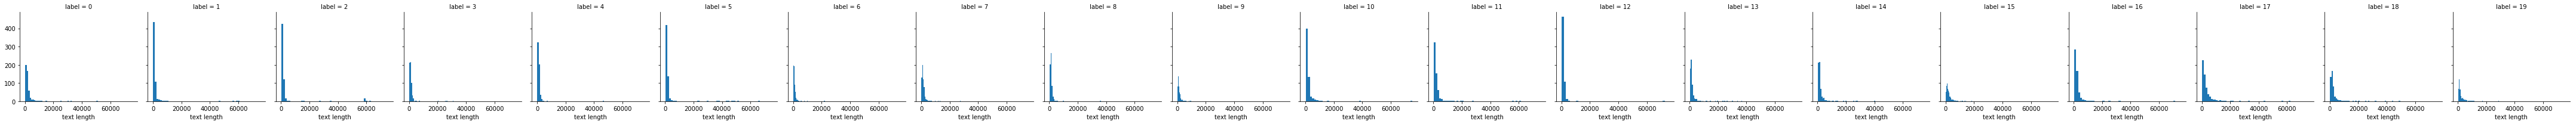

In [42]:
g = sns.FacetGrid(data=data_2, col='label')
g.map(plt.hist, 'text length', bins=50)

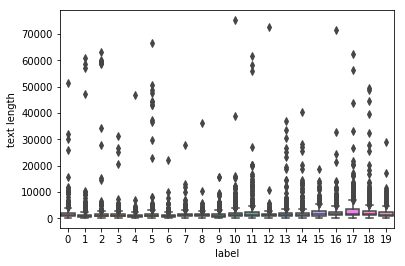

In [43]:
sns.boxplot(x='label', y='text length', data=data_2)

In [84]:
PATH = "/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/model_22.pickle"
model = build_and_evaluate(X_2[:500],y_2[:500], outpath=PATH)

Building for evaluation


/anaconda3/envs/py36/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Evaluation model fit in 13.229 seconds
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.17      0.33      0.22         3
           2       0.67      0.80      0.73         5
           3       0.33      1.00      0.50         2
           4       0.75      0.43      0.55         7
           5       0.50      0.20      0.29         5
           6       0.50      0.22      0.31         9
           7       0.67      0.50      0.57         4
           8       0.60      1.00      0.75         3
           9       0.71      0.56      0.63         9
          10       0.88      1.00      0.93         7
          11       0.88      1.00      0.93         7
          12       0.40      0.40      0.40         5
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         7
          15       0.80      1.00      0.89         8
          16      

In [88]:
with open("/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/model_22.pickle", 'rb') as f:
    model = pickle.load(f)
print(show_most_informative_features(model))

3.5096          keith    -2.0469             ax
2.4341          strom    -1.6813        believe
1.9489            sex    -1.6412            msg
1.8228        caltech    -1.5734           bear
1.7205       okcforum    -1.4783         father
1.7086          chimp    -1.4716             lm
1.5376        islamic    -1.4060            com
1.5358           kmr4    -1.3924       cs1442aq
1.5303       religion    -1.3659            ssc
1.4910            tut    -1.3639         weapon
1.4691          satan    -1.3543           mass
1.4638      schneider    -1.3259           jake
1.4237        fallacy    -1.2617         berger
1.4029       evidence    -1.2303         priest
1.3817         whirrr    -1.2214         laptop
1.3294       khomeini    -1.2123       armenian
1.3294        rushdie    -1.1932         spirit
1.3235          bobby    -1.1821           navo
1.2868          moral    -1.1821       finnegan
1.2845         stupid    -1.1796           hell


### RNN Tensorflow manual

In [490]:
def tokenize(document):
    """
    Returns a normalized, lemmatized list of tokens from a document by
    applying segmentation (breaking into sentences), then word/punctuation
    tokenization, and finally part of speech tagging. It uses the part of
    speech tags to look up the lemma in WordNet, and returns the lowercase
    version of all the words, removing stopwords and punctuation.
    """
    lemmatized_tokens = []
    # Break the document into sentences
    for sent in sent_tokenize(document):
        # Break the sentence into part of speech tagged tokens
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # Apply preprocessing to the token
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If punctuation or stopword, ignore token and continue
            if token in sw.words('english') or all(char in set(string.punctuation) for char in token) or len(token)<=1:
                continue

            # Lemmatize the token and yield
            lemma = lemmatize(token, tag)
            lemmatized_tokens.append(lemma)
    return ' '.join(lemmatized_tokens)

def lemmatize(token, tag):
    """
    Converts the Penn Treebank tag to a WordNet POS tag, then uses that
    tag to perform much more accurate WordNet lemmatization.
    """
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return WordNetLemmatizer().lemmatize(token, tag)


In [4]:
# Load the input data
wordsList = np.load('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/training_data/wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/training_data/wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


In [5]:
# Retrieve some info on the text data to chose RNN parameters
numWords = []
for text in X:
        counter = len(text.split())
        numWords.append(counter)       

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

The total number of files is 2000
The total number of words in the files is 1492681
The average number of words in the files is 746.3405


In [99]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())


# Build the integerized matrix of the texts
maxSeqLength = 750
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
fileCounter = 0
for text in X:
        indexCounter = 0
        cleanedLine = cleanSentences(text)
        lemmatizedLine = tokenize(cleanedLine)
        split = lemmatizedLine.split()
        for word in split:
            try:
                ids[fileCounter][indexCounter] = wordsList.index(word)
            except ValueError:
                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
            indexCounter = indexCounter + 1
            if indexCounter >= maxSeqLength:
                break
        fileCounter = fileCounter + 1 

np.save('idsMatrix_movie_revies', ids)

In [27]:
# If the ids file has already been created
maxSeqLength = 750
ids = np.load('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/idsMatrix_movie_revies.npy')

In [11]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,899)
            labels.append([1,0])
        else:
            num = randint(1100,1999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(899,1100)
        if (num <= 999):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

In [18]:
numDimensions = 50
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 1000

tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [20]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

# For tensorboard visualization
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

/anaconda3/envs/py36/lib/python3.5/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [21]:
for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})

#Write summary to Tensorboard
if (i % 2 == 0):
    summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
    writer.add_summary(summary, i)
#Save the network every 10,000 training iterations
#if (i % 10000 == 0 and i != 0):
save_path = saver.save(sess, "/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/models_2/pretrained_lstm.ckpt", global_step=1000)
print("saved to %s" % save_path)
writer.close()

saved to /Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/models_2/pretrained_lstm.ckpt-1000


In [22]:
# To test the ongoin model on a test set
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/models_2'))

iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

INFO:tensorflow:Restoring parameters from /Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/LSTM-Sentiment-Analysis-master/models_2/pretrained_lstm.ckpt-1000


/anaconda3/envs/py36/lib/python3.5/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Accuracy for this batch: 62.5
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 29.16666567325592
Accuracy for this batch: 75.0
Accuracy for this batch: 79.16666865348816
Accuracy for this batch: 29.16666567325592
Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 70.83333134651184
Accuracy for this batch: 45.83333432674408


### RNN Keras manual

In [54]:
# Params
max_sentence_len = 1500
max_features = 30000
embed_dim = 300
lstm_out = 196

# Training params
batch_size = 256 
num_epochs = 7

In [650]:

def tokenize(document):
    """
    Returns a normalized, lemmatized list of tokens from a document by
    applying segmentation (breaking into sentences), then word/punctuation
    tokenization, and finally part of speech tagging. It uses the part of
    speech tags to look up the lemma in WordNet, and returns the lowercase
    version of all the words, removing stopwords and punctuation.
    """
    lemmatized_tokens = []
    # Break the document into sentences
    for sent in sent_tokenize(document):
        # Break the sentence into part of speech tagged tokens
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # Apply preprocessing to the token
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If punctuation or stopword, ignore token and continue
            if token in sw.words('english') or all(char in set(string.punctuation) for char in token) or len(token)<=1:
                continue

            # Lemmatize the token and yield
            lemma = lemmatize(token, tag)
            lemmatized_tokens.append(lemma)
    temp = ' '.join(lemmatized_tokens)
    temp2 = vectorize(np.array(temp)[np.newaxis])
    return temp2

def vectorize(doc):
    save_path = "/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/padding.pickle"
    with open(save_path, 'rb') as f:
        tokenizer = pickle.load(f)
    doc_pad = tokenizer.texts_to_sequences(doc)
    doc_pad = pad_sequences(doc_pad, padding = 'pre', truncating = 'pre', maxlen = 702)
    return np.squeeze(doc_pad)



def lemmatize(token, tag):
    """
    Converts the Penn Treebank tag to a WordNet POS tag, then uses that
    tag to perform much more accurate WordNet lemmatization.
    """
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return WordNetLemmatizer().lemmatize(token, tag)


def transform(X):
    """
    Actually runs the preprocessing on each document.
    """
    return [(tokenize(doc)) for doc in X]

In [161]:
for i in range(len(X)):
        text  = tokenize(X[i])
        X[i] = text

In [163]:
# Retrieve some info on the text data to chose RNN parameters
numWords = []
for text in X:
        counter = len(text.split())
        numWords.append(counter)       

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

The total number of files is 2000
The total number of words in the files is 705077
The average number of words in the files is 352.5385


In [477]:
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X)
X_pad = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_pad, padding = 'pre', truncating = 'pre', maxlen = 300)
y_pad = pd.get_dummies(y).values

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))
print(X_pad.shape)

Found 43296 unique tokens.
(1, 300)


In [478]:
save_path = "/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/padding.pickle"

with open(save_path, 'wb') as f:
            pickle.dump(tokenizer, f)

with open(save_path, 'rb') as f:
    tok = pickle.load(f)

In [470]:
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_pad.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 250, 300)          60000000  
_________________________________________________________________
spatial_dropout1d_21 (Spatia (None, 250, 300)          0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 196)               389648    
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 394       
Total params: 60,390,042
Trainable params: 60,390,042
Non-trainable params: 0
_________________________________________________________________
None


In [471]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pad,y_pad, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

ValueError: Found input variables with inconsistent numbers of samples: [1, 2000]

In [703]:
# Model file name
model_name = 'RNN_regular_1'

# model path
save_path = '/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Models/'

# Load JSON
json_file = open(save_path + model_name + '.json', 'r')

# Create model
model = model_from_json(json_file.read())

# Load weights into model
model.load_weights(save_path + model_name + '.h5')
 
# evaluate loaded model on test data
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

# Close model file
json_file.close()

In [176]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
 - 83s - loss: 0.6964 - acc: 0.5433
Epoch 2/7
 - 76s - loss: 0.5374 - acc: 0.7604
Epoch 3/7
 - 77s - loss: 0.4027 - acc: 0.8261
Epoch 4/7
 - 79s - loss: 0.3207 - acc: 0.8739
Epoch 5/7
 - 78s - loss: 0.2567 - acc: 0.8948
Epoch 6/7
 - 77s - loss: 0.2395 - acc: 0.9045
Epoch 7/7
 - 77s - loss: 0.2013 - acc: 0.9134


In [177]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.61
acc: 0.75


In [260]:
# Model file name
model_name = 'RNN_regular_1'

# Save path
save_path = '/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Models/'

# Save model's weights to HDF5 format
model.save_weights(save_path + model_name + '.h5')

# Save model to JSON format
with open(save_path + model_name + '.json', 'w') as json_file:
    json_file.write(model.to_json())

### Full Google Word2Vec

In [ ]:
for text in X:
        cleanedLine = cleanSentences(text)
        text = tokenize(cleanedLine)

In [95]:
def load_google_vec():
    return KeyedVectors.load_word2vec_format('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Text/Text/GoogleNews-vectors-negative300.bin', binary=True)

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, splitted_corpus, generate_missing=False):
    embeddings = splitted_corpus.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

word2vec = load_google_vec()
training_embeddings = get_word2vec_embeddings(word2vec, pd.Series((v for v in splitted_corpus) ), generate_missing=True)

NameError: name 'gensim' is not defined

In [125]:
tokenizer = Tokenizer(num_words=max_features, lower=True, char_level=False)
tokenizer.fit_on_texts(X)
X_pad = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_pad, maxlen = max_sentence_len, padding = 'post', truncating = 'post')
y_pad = pd.get_dummies(data['label']).values

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

# Extra step for word embedding using the Google Word2Vec
train_embedding_weights = np.zeros((len(train_word_index)+1, embedding_dim))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(embedding_dim)

print(train_embedding_weights.shape)

Found 43296 unique tokens.
(43297, 300)


In [128]:
model = Sequential()
model.add(Embedding(len(train_word_index)+1,300,weights=[train_embedding_weights],input_length= max_sentence_len,trainable=False))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1894, 300)         12989100  
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 1894, 300)         0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 196)               389648    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 394       
Total params: 13,379,142
Trainable params: 390,042
Non-trainable params: 12,989,100
_________________________________________________________________
None


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pad,y_pad, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [131]:
model.fit(X_train, Y_train, epochs = num_epochs, batch_size=batch_size, verbose = 2)

Epoch 1/7
 - 146s - loss: 0.6889 - acc: 0.5465
Epoch 2/7
 - 147s - loss: 0.6548 - acc: 0.6150
Epoch 3/7
 - 148s - loss: 0.6393 - acc: 0.6305
Epoch 4/7
 - 157s - loss: 0.6276 - acc: 0.6345
Epoch 5/7
 - 152s - loss: 0.5998 - acc: 0.6685
Epoch 6/7


KeyboardInterrupt: 

In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

### T_SNE Visualization

In [3]:
def load_google_vec():
    return KeyedVectors.load_word2vec_format('/Users/raphaellederman/Library/Mobile Documents/com~apple~CloudDocs/MasterDS/Fil_Rouge/Text/Text/GoogleNews-vectors-negative300.bin', binary=True)


def extract_list_and_vectors(model):
    if type(model) is gensim.models.word2vec.Word2Vec:
        List = list(model.wv.vocab)
        Vectors = np.asarray([model.wv[w] for w in List])
    else:
        List = list(model.vocab)
        Vectors = np.asarray([model[w] for w in List])

    return List, Vectors

In [107]:
word2vec = load_google_vec()
wordsList_complete, wordVectors_complete = extract_list_and_vectors(word2vec)

In [4]:
def tsne_plot(Vectors,List, n_elements):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    l_bound = 0
    u_bound = len(List)
    step = int(len(List)/n_elements)

    for index in range(l_bound,u_bound, step):
        tokens.append(Vectors[index])
        labels.append(List[index])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    xx = []
    yy = []
    for value in new_values:
        xx.append(value[0])
        yy.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(xx)):
        plt.scatter(xx[i],yy[i])
        plt.annotate(labels[i],
                     xy=(xx[i], yy[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


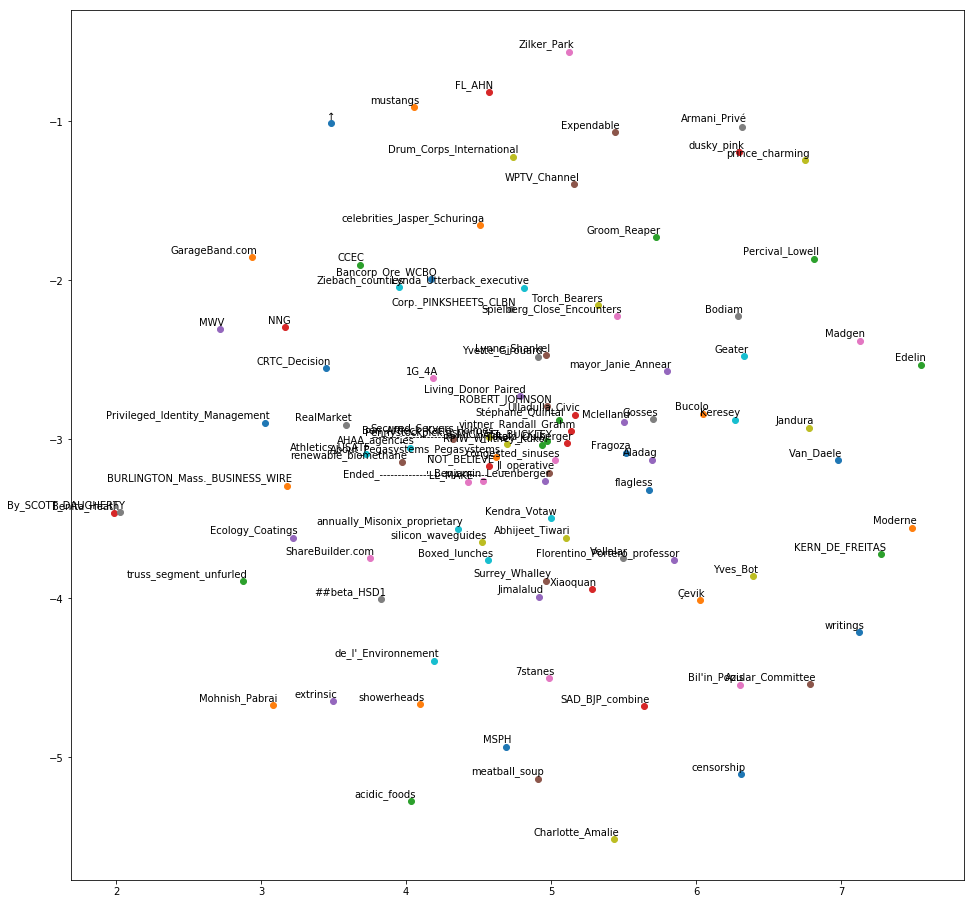

In [69]:
tsne_plot(wordVectors_complete,wordsList_complete, 200)

In [63]:
splitted_corpus = [tokenize.word_tokenize(text) for text in X]
word2vec_corpus = word2vec.Word2Vec(splitted_corpus, size=100, window=20, min_count=200, workers=4)
wordsList_corpus, wordVectors_corpus = extract_list_and_vectors(word2vec_corpus)

NameError: name 'extract_list_and_vectors' is not defined

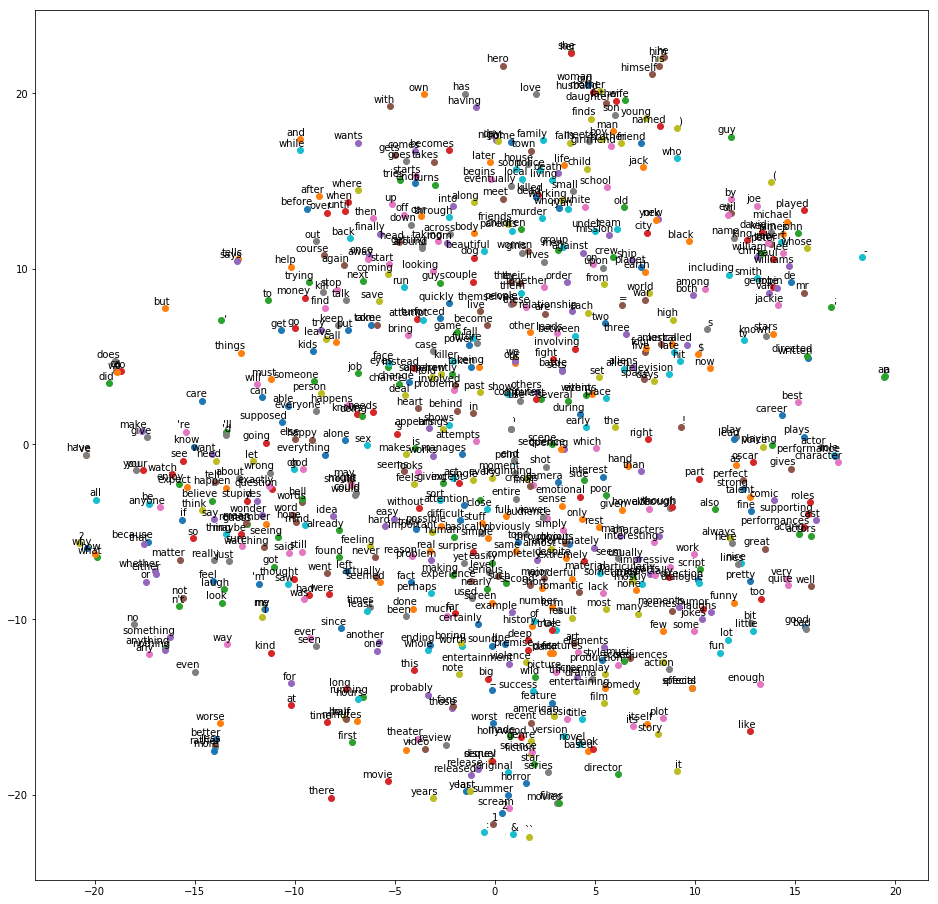

In [142]:
tsne_plot(wordVectors_corpus,wordsList_corpus, 500)

### Bonus

In [ ]:
'''
Single model may achieve LB scores at around 0.29+ ~ 0.30+
Average ensembles can easily get 0.28+ or less
Don't need to be an expert of feature engineering
All you need is a GPU!!!!!!!

The code is tested on Keras 2.0.0 using Tensorflow backend, and Python 2.7

According to experiments by kagglers, Theano backend with GPU may give bad LB scores while
        the val_loss seems to be fine, so try Tensorflow backend first please
'''

########################################
## import packages
########################################
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import sys
reload(sys)
sys.setdefaultencoding('utf-8')

########################################
## set directories and parameters
########################################
BASE_DIR = '../input/'
EMBEDDING_FILE = BASE_DIR + 'GoogleNews-vectors-negative300.bin'
TRAIN_DATA_FILE = BASE_DIR + 'train.csv'
TEST_DATA_FILE = BASE_DIR + 'test.csv'
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1

num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

act = 'relu'
re_weight = True # whether to re-weight classes to fit the 17.5% share in test set

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

########################################
## index word vectors
########################################
print('Indexing word vectors')

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, \
        binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

########################################
## process texts in datasets
########################################
print('Processing text dataset')

# The function "text_to_wordlist" is from
# https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

texts_1 = [] 
texts_2 = []
labels = []
with codecs.open(TRAIN_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        texts_1.append(text_to_wordlist(values[3]))
        texts_2.append(text_to_wordlist(values[4]))
        labels.append(int(values[5]))
print('Found %s texts in train.csv' % len(texts_1))

test_texts_1 = []
test_texts_2 = []
test_ids = []
with codecs.open(TEST_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        test_texts_1.append(text_to_wordlist(values[1]))
        test_texts_2.append(text_to_wordlist(values[2]))
        test_ids.append(values[0])
print('Found %s texts in test.csv' % len(test_texts_1))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)

sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(labels)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
test_ids = np.array(test_ids)

########################################
## prepare embeddings
########################################
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

########################################
## sample train/validation data
########################################
#np.random.seed(1234)
perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
labels_train = np.concatenate((labels[idx_train], labels[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))

weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344

########################################
## define the model structure
########################################
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

########################################
## add class weight
########################################
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

########################################
## train the model
########################################
model = Model(inputs=[sequence_1_input, sequence_2_input], \
        outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])
#model.summary()
print(STAMP)

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

hist = model.fit([data_1_train, data_2_train], labels_train, \
        validation_data=([data_1_val, data_2_val], labels_val, weight_val), \
        epochs=200, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

########################################
## make the submission
########################################
print('Start making the submission before fine-tuning')

preds = model.predict([test_data_1, test_data_2], batch_size=8192, verbose=1)
preds += model.predict([test_data_2, test_data_1], batch_size=8192, verbose=1)
preds /= 2

submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
submission.to_csv('%.4f_'%(bst_val_score)+STAMP+'.csv', index=False)